LISTA DE LIBRERIAS

In [600]:
# graficar datos

import matplotlib.pyplot as plt # libreria de visualizacion de datos
import plotly.graph_objects as go # libreria de visualizacion de datos
import missingno as msno # libreria para graficar nullos 


# manipulacion de informacion y estadistica

import numpy as np # libreria estadistica 
import pandas as pd # libreria de manipulacion de dataframes


# conexion a bases de datos

import pyodbc # libreria de conexion a bases de datos 
import sqlite3 # libreria de conexion a bases de datos 


# librerias de sklearn 

# modelos

# arbol de decisiones 
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor

# ForestRegressor
from sklearn.ensemble import RandomForestRegressor

# modelos de regresion lienal 
from sklearn.linear_model import LinearRegression

# Support Vector Regression
from sklearn.svm import SVR 

# normalizacion

# libreria de normalizacion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# nullos

from sklearn.impute import SimpleImputer #permite especificar el valor a reemplazar (puede ser algo diferente a NaN) 
# y la técnica utilizada para reemplazarlo (como media, mediana o moda)

from sklearn.ensemble import IsolationForest

# entrenamiento

# divide el data set en prueba y entrenamiento
from sklearn.model_selection import train_test_split


# libreria de metricas de control 

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error 

# librearia busqueda hiper paramertos
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from skopt import BayesSearchCV

# feature ingeniering
from sklearn.preprocessing import PolynomialFeatures


# libreria scipy


import scipy 

# libreria correlacion
from scipy.stats import pointbiserialr, spearmanr, pearsonr, contingency


# librerias de boosting
from lightgbm import LGBMRegressor # NUEVO
from xgboost import XGBRegressor
from catboost import CatBoostRegressor # NUEVO

# errores 
import warnings

warnings.filterwarnings('ignore')

# aleatorio
from scipy.stats import randint
import random

import os






In [601]:
# codigo para ver todas las filas de un dataframe
pd.set_option('display.max_rows', None)

CONEXION CON LA BASE DE DATOS 

In [602]:
# %% [markdown]

server = 'DESKTOP-K6T3N2G'
database = 'reparaciones'
username = ''
password = ''
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

## Querys SQL server

QUERY DE CLIENTES

In [603]:
consumer = pd.read_sql_query("""

SELECT 

 RTRIM(LTRIM(CUSTID_23)) AS  CUSTID_23
,RTRIM(LTRIM(NAME_23)) AS  NAME_23
,RTRIM(LTRIM(CITY_23)) AS  CITY_23
,RTRIM(LTRIM(CNTRY_23)) AS  CNTRY_23



FROM pruebas.[dbo].[Custumer]

""", cnxn)

QUERY DE LOS PRODUCTOS 

In [604]:
productos = pd.read_sql_query("""

SELECT 

 RTRIM(LTRIM(PRTNUM_01)) AS PRTNUM_01
,PMDES1_01

FROM pruebas.[dbo].[part_master]

""", cnxn)

QUERY DE CLASIFICACION DE LOS PRODCUTOS POR CATEGORIA 

In [605]:
linea = pd.read_sql_query("""
select 

 RTRIM(LTRIM(CLASIFICACION)) AS  CLASIFICACION
,LINEA

from linea

""", cnxn)

QUERY DE LAS UNIDADES QUE LLEGAN A REPARAR

In [606]:
df = pd.read_sql_query("""

WITH RESUMEN AS (

SELECT 

 rmamrp_id
,RTRIM(LTRIM(rmamrp_rma)) AS rmamrp_rma
,RTRIM(LTRIM(rmamrp_mrp)) AS rmamrp_mrp
,rmamrp_color
,regrep_serial
,rmamrp_cantidad
,regrep_orden_diagyrep
,rma_fecha_creacion
,year(rma_fecha_creacion) as año
---,DATE_FORMAT(rma_fecha_creacion, '%Y-%m') as fecha_mes_año
,regrep_fecha_fabricacion
,regrep_fecha_diagnostico
,regrep_estado_garantia
,CASE WHEN regrep_estado_garantia=1 THEN 'CON GARANTIA' ELSE 'SIN GARANTIA' END AS ESTADO 
,rma_years_garantia
,RTRIM(LTRIM(rma_cliente))AS rma_cliente
,ACTTYP_01
,LINEA
,NAME_23


FROM  [eclipticdb rma_mrps]
		INNER JOIN [eclipticdb rma_regs_rep]
			ON rmamrp_id=regrep_rmamrp
		LEFT JOIN [eclipticdb rma_rmas]
			ON rmamrp_rma=rma_id
		LEFT JOIN pruebas.[dbo].[part_master]
			ON rmamrp_mrp=PRTNUM_01
		LEFT JOIN linea
			ON ACTTYP_01=CLASIFICACION
		LEFT JOIN pruebas.[dbo].[Custumer]
			ON rma_cliente=CUSTID_23
		
WHERE LTRIM(rmamrp_mrp) NOT LIKE 'G%' AND LTRIM(rmamrp_mrp) NOT LIKE 'D%' --ORDER BY rmamrp_rma DESC



) SELECT 

	 rma_fecha_creacion
	,regrep_orden_diagyrep
	,año
	,rmamrp_rma
	,rmamrp_mrp
	,LINEA
	,rmamrp_color
	,regrep_estado_garantia
	,ESTADO
	,rma_years_garantia
	,rma_cliente
    ,NAME_23
	,ACTTYP_01
	,count(rmamrp_rma) as cantidad

	
	
	FROM RESUMEN


	group by rmamrp_rma,rmamrp_mrp,año,regrep_orden_diagyrep,ESTADO,rmamrp_color,rma_fecha_creacion,regrep_estado_garantia
			,rma_years_garantia,rma_cliente,ACTTYP_01,LINEA,NAME_23

			order by rma_fecha_creacion,rmamrp_rma desc

""", cnxn)

## Query Unificada con productos Y tabla de clientes

In [607]:
# tabla de producto
unificada=pd.merge(df,productos, left_on='rmamrp_mrp', right_on='PRTNUM_01',how='left')

# tabla de clientes
unificada=pd.merge(unificada,consumer, left_on='rma_cliente', right_on='CUSTID_23',how='left')

In [608]:
# seleccionamos las columnas necesartias del merge de las dos tablas de clientes y productos
unificada=unificada[['rma_fecha_creacion','regrep_orden_diagyrep','año','rmamrp_rma','rmamrp_mrp','LINEA','rmamrp_color','regrep_estado_garantia','ESTADO','rma_years_garantia','rma_cliente','NAME_23_x','ACTTYP_01','cantidad','PMDES1_01','CITY_23','CNTRY_23']]

# se renombra la columna name_23 al estar en dos tablas  la variable como NAME_23_x 
unificada=unificada.rename(columns={'NAME_23_x':'NAME_23'})

# seccion verificacion de nullos

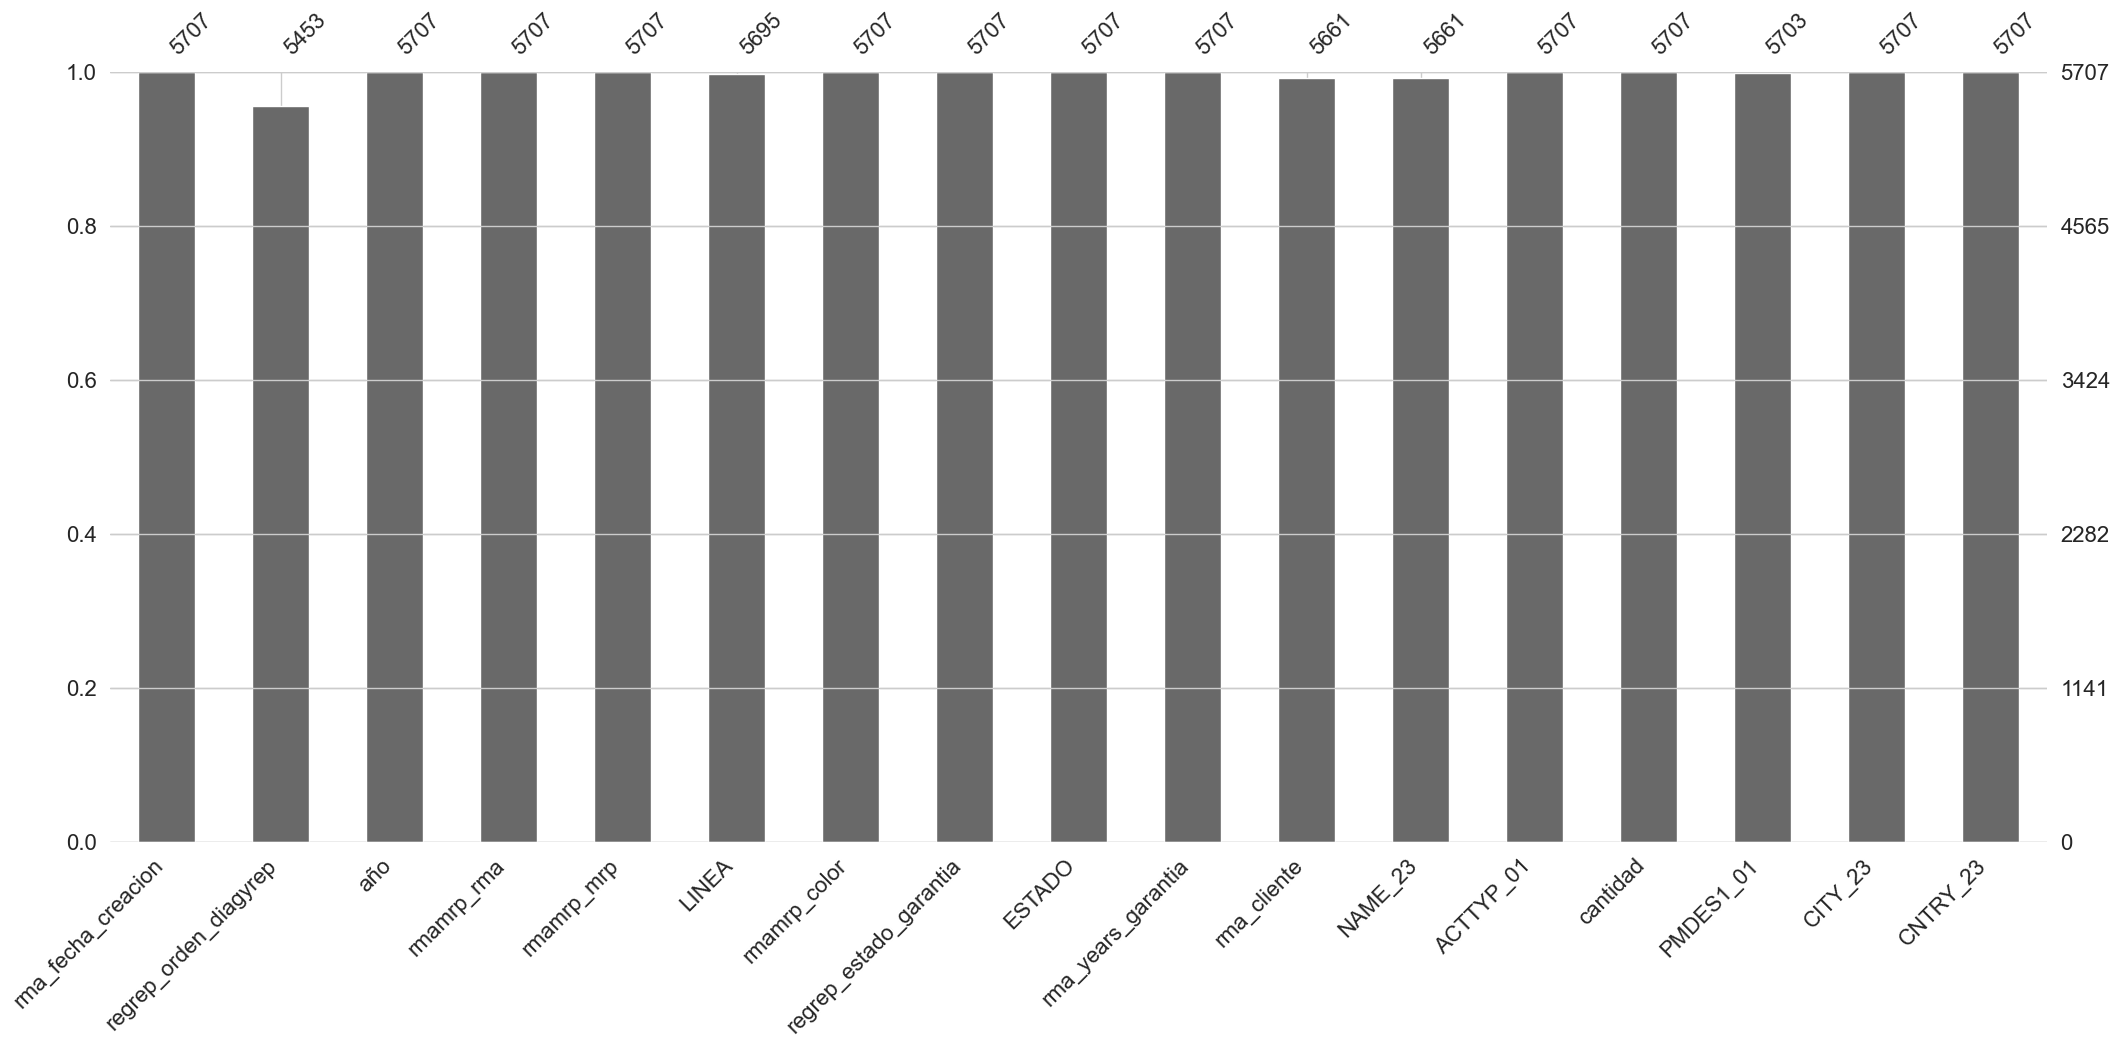

In [609]:
# se grafica los valores nullos con la funcion msno
plt.figure(figsize=(3, 3))
msno.bar(unificada)
plt.show()


In [610]:
# se crea tabla identificando las columnas con valores nullos tabla de columnas nullos

nullo=unificada.isnull().sum().sort_values(ascending=False).reset_index().head(8)


# se renombra columnas
nullo=nullo.rename(columns={'index': 'columnas'})

# se crea nueva columna 
nullo['valores']=nullo.iloc[:,1]

# se crea columna de acumulado de cantidad de nullos
nullo['acumulado_cantidad']= nullo['valores'].cumsum()

# se filtra las columnas 
nullo=nullo[['columnas','valores','acumulado_cantidad']]

# se calcula porcentaje de nullos segun el total de filas se toma como referencia para el conteo la fecha de creacion
nullo['porcentaje']=(nullo['valores']/unificada.rma_fecha_creacion.count())*100

# acumulado de nullos
nullo['acumulado  %']= nullo.porcentaje.cumsum()

nullo=nullo[nullo['valores']>0]
nullo

# se identifica la columna regrep_orden_diagyrep con mayor porcentaje de valores nullos a si mismo el porcentaje total de valores nullos es del 
# 6% porciento frente al total de valores


,columnas,valores,acumulado_cantidad,porcentaje,acumulado %
0,regrep_orden_diagyrep,254,254,4.450675,4.450675
1,rma_cliente,46,300,0.806028,5.256702
2,NAME_23,46,346,0.806028,6.062730
3,LINEA,12,358,0.210268,6.272998
4,PMDES1_01,4,362,0.070089,6.343087


In [611]:

# se procedera aplicar FEATURE ENGINEERING a la columna regrep_orden_diagyrep esto con el fin 
# enriquezer el data set con los valores nullos de esta columna que puede ser de ayuda a la hora de modelar 
#unificada['regrep_orden_diagyrep_']=np.where(unificada.regrep_orden_diagyrep.isnull,1,0)

# se drop la columna regrep_orden_diagyrep con el fin de no duplicar columnas que apuntan a la misma informacion
# se deja la columna regrep_orden_diagyrep_ con los valores de FEATURE ENGINEERING
#unificada=unificada.drop('regrep_orden_diagyrep',axis=1)

In [612]:

# Reemplazo 'NaN' con el valor mas contado de los clientes
conteo_filax=unificada.NAME_23.value_counts().head(1).reset_index().iloc[0,0]
unificada['NAME_23']= unificada.NAME_23.replace({'NAN': conteo_filax})

In [613]:

# en las calumnas rma_cliente, se cambia los nullos por cero 
unificada['rma_cliente']=unificada.rma_cliente.replace(np.NAN, 0)


In [614]:
# se remplaza los nullos restantes en las columnas PRTNUM_01, PMDES1_01, ACTTYP_01_y
unificada=unificada.replace(np.NAN, 0)

In [615]:
# se verifica los valores que contiene el feature de LINEA
unificada.LINEA.unique()

array(['Luminarias Led', 0, 'sin clasificar'], dtype=object)

## duplicados

In [616]:
# sumamos el numero de duplicados del data set
unificada.duplicated().sum()

8

In [617]:
# se borra duplicados
unificada=unificada.drop_duplicates()

## categorias

In [618]:
# hace distinct en el feature ACTTYP_01_x la cual es el parametro que categoriza la linea
unificada[unificada.LINEA.isna()].ACTTYP_01.unique()

array([], dtype=object)

In [619]:
# categorizar el MN1,PP1 como valores sin clasificar
unificada['LINEA']=np.where(unificada.ACTTYP_01=='MN1','Muestras',np.where(unificada.ACTTYP_01=='PP1','sin clasificar',unificada.LINEA))


se filtra las columnas que son categoricas

In [620]:
# filtramos las columnas que son categoricas

columnas_no_numericas=[]

for columna in unificada.columns:
    if not pd.api.types.is_numeric_dtype(unificada[columna]):
        columnas_no_numericas.append(columna)

columnas_no_numericas

['rma_fecha_creacion',
 'rmamrp_rma',
 'rmamrp_mrp',
 'LINEA',
 'rmamrp_color',
 'ESTADO',
 'rma_cliente',
 'NAME_23',
 'ACTTYP_01',
 'PMDES1_01',
 'CITY_23',
 'CNTRY_23']

In [621]:
# se verifica cuantas categorias tiene cada feature y se guarda en un diccionario 
diccionario={}
for i in  unificada.columns:
    if i in columnas_no_numericas:
        #unico=unificada[i].nunique()
        diccionario[i]=unificada[i].nunique()
    else:
        continue
    
diccionario

{'rma_fecha_creacion': 281,
 'rmamrp_rma': 714,
 'rmamrp_mrp': 483,
 'LINEA': 3,
 'rmamrp_color': 52,
 'ESTADO': 2,
 'rma_cliente': 79,
 'NAME_23': 79,
 'ACTTYP_01': 4,
 'PMDES1_01': 448,
 'CITY_23': 56,
 'CNTRY_23': 12}

In [622]:
# se itera el diccionario con el fin de verificar las columnas con categorias menores a 10 y asi hacer una transformacion de getdumies en esas columnas la cuales puedan aporta

colum_getdummies={}
for colum, value in  diccionario.items():
    if value<10:
        colum_getdummies[colum]=value
print(colum_getdummies)



{'LINEA': 3, 'ESTADO': 2, 'ACTTYP_01': 4}


 feature enginering PT1 One-hot encoding

In [623]:
# aplicamos get dummies a las columas del diccionario colum_getdummies

# se le aplica get_dummies a la columna de estado que tiene dos categorias diferentes
unificada = pd.get_dummies(unificada, columns=['ESTADO'])

# se aplica get_dammies a la columna de linea 
unificada = pd.get_dummies(unificada, columns=['LINEA'])

#agregando 4 nuevas columnas con variables categoricas de la columna de estado y linea

unificada['regrep_orden_diagyrep_']=np.where(unificada.regrep_orden_diagyrep.isnull,1,0)

renombrar las nuevas columnas con getdamies

In [624]:
# rename en la categoria luminaria led
unificada=unificada.rename(columns={'LINEA_Luminarias Led':'led'})

# rename en la categoria LINEA_sin clasificar
unificada=unificada.rename(columns={'LINEA_sin clasificar':'sin_clasificar'})

# rename en la categoria LINEA_Muestras
unificada=unificada.rename(columns={'LINEA_Muestras':'Muestras'})

## outliers

Método IQR

In [625]:
#filtramos las columnas numericas 
# la variable rmamrp_cantidad seria el feature al cual se le va hacer seguimiento con los difenres analisis

numericas=[]

for columna in unificada.columns:
    if  pd.api.types.is_numeric_dtype(unificada[columna]):
        numericas.append(columna)

numericas=numericas[3]
numericas


'rma_years_garantia'

In [626]:
# por medio de esta tecnica podemos filtrar los valores de cantidad y asi identificar los datos outliers

Q1=unificada.cantidad.quantile(0.25)
Q3=unificada.cantidad.quantile(0.75)
IQR=Q3-Q1

#limites

limite_inferior=Q1-1.5*IQR
limite_superior=Q3+1.5*IQR

print(f'L inferior: {limite_inferior} L superior: {limite_superior}')

# se filtra data set con el valor inferior y maximo del rango
#unificada=unificada[(unificada.cantidad>limite_inferior)  &  (unificada.cantidad<limite_superior)]

L inferior: -9.5 L superior: 18.5


In [627]:
media=unificada.cantidad.mean()
desviacion_estandar=unificada.cantidad.std()

umbral=3

#agregamos la variable zcore al dataframe
unificada['z_core']=((unificada.cantidad-media)/desviacion_estandar).abs()
print(f'z core minimo: {unificada['z_core'].min()},  z core maximo: {unificada['z_core'].max()}')

z core minimo: 0.0005610888156643216,  z core maximo: 15.738259136432902


## Medidas  detendencia central 


In [628]:
# la centralidad de los datos se encuentra en 15 unidades

media=unificada.cantidad.mean()
media_geometrica=scipy.stats.gmean(unificada.cantidad)
# media quitando el 10 porciento de los datos en los extremos
media_recortada=scipy.stats.trim_mean(unificada.cantidad,0.1)
moda=scipy.stats.mode(unificada.cantidad) # Moda
maximo=np.max(unificada.cantidad)
minimo=np.min(unificada.cantidad)
rango=maximo-minimo

In [629]:
resumen = {  
           
             'media': round(media, 1)
           , 'media geometrica':round(media_geometrica,1)
           , 'media recortada':round(media_recortada,1)
           , 'moda':moda
           , 'maximo':maximo
           , 'minimo':minimo
           , 'rango':rango
           
           }


resumen=pd.DataFrame.from_dict(resumen, orient='index', columns=['valor'])
resumen

,valor
media,35.9
media geometrica,3.9
media recortada,5.2
moda,"(1, 2010)"
maximo,3491
minimo,1
rango,3490


 ## Medidas de dispersion

In [630]:

# la desviacion de los datos respecto a la media central es de 
# mas o menos 54 unidades
desviacion_estandar=np.std(unificada.cantidad)
coeficientes_variacion=scipy.stats.variation(unificada.cantidad)
IQR_SCIPY=scipy.stats.iqr(unificada.cantidad) # Calcular el IQR
limite_inferior = Q1 - 1.5 * IQR_SCIPY
limite_superior = Q3 + 1.5 * IQR_SCIPY

In [631]:
resumen_dispersion= {
    
    'desviacion estandar': round(desviacion_estandar,1)
    ,'variacion': round(coeficientes_variacion,1)
    ,'IQR':IQR_SCIPY
    ,'Limite inferior':limite_inferior
    ,'Limite superior':limite_superior
    }

resumen_dispersion=pd.DataFrame.from_dict(resumen_dispersion, orient='index', columns=['valor'])
resumen_dispersion

,valor
desviacion estandar,219.5
variacion,6.1
IQR,7.0
Limite inferior,-9.5
Limite superior,18.5


## Medidas de asimetria

kurtosis

Este coeficiente es siempre mayor
o igual que uno. El coeficiente de curtosis es importante porque nos informa respecto a la heterogeneidad de la distribución.

1. Si es muy bajo (menor de 2), indica una distribución mezclada
2. si es muy alto (mayor de 6), indica
la presencia de valores extremos atípicos.

In [632]:
# por lo que el valor de 68 en la kurtosis indica la presencia de valores atipicos
scipy.stats.kurtosis(unificada.cantidad) 

145.16214308996354

In [633]:
# medida de asimetria a la derecha la cola de la distribución 
# se extiende para valores superiores a la media

print('medida de asimetria: ',scipy.stats.skew(unificada.cantidad), 'media: ',media) # Calcular el CA

medida de asimetria:  11.397948608801288 media:  35.876820494823654


## Datos atipicos

Text(0.5, 0, 'unidades')

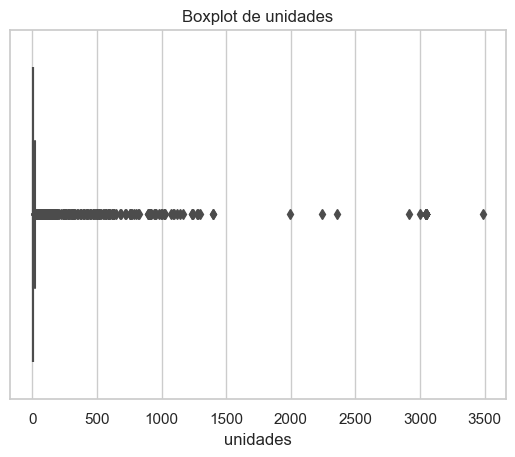

In [634]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=unificada.cantidad)
plt.title('Boxplot de unidades')
plt.xlabel('unidades')

In [635]:

# porcentaje de datos outliers frente al total de la muestra 
(unificada[unificada.cantidad > 18].cantidad.count()/unificada.cantidad.count())*100


15.090366731005439

se identifica en el boxplot que cifras superiores a 18 unidades se categorizan como datos atipicos o outliers, cabe mencionar que en pasos anteriores se realiza IQR, sin embargo se vuelve a realizar un control de outliers con el metodo de boxplot y se encuentra que  los datos outliers representan el 14 % porciento de los datos totales del data set.



se realizara un filtro del data set, seleccionando los productos mas significativos en cuanto a unidades de reparacion esto con el fin de centrar la investigacion en los productos con mayor participacion en postventa, y asi mismo identificar si existe un mismo patron estadistico en los datos segmentados.

## Analisis univariado

¿Cuáles son los productos que tienen la mayor participación en el número de unidades que requieren ser reparadas en el servicio postventa?

In [636]:
# se agrupa el data set por categoria producto
productos=unificada.groupby('rmamrp_mrp')['cantidad'].sum().sort_values(ascending=False).reset_index()

# nullo.porcentaje.cumsum()

# uma=unificada.cantidad.sum()

# se crea columna  
productos['%']=round((productos.cantidad/unificada.cantidad.sum())*100,)
productos['acumulado_%']=round(((productos.cantidad/unificada.cantidad.sum()).cumsum())*100,1)

In [637]:
# producto con mayor representacion de unidades a reparar 
codigo=productos.iloc[0,0]

se realiza un conteo de los productos con mayor unidades de reparaciones, se identifica que la data cuenta con 483 productos diferentes reparados, que suman 87 mil unidades reparadas aproximadamente, asi mismo los 5 productos iniciales con mayor reparaciones cuenta con mas del 50 % de las unidades reparadas, siendo el primer item con 22 mil unidades y con una participacion del 25% porciento de las reparaciones y el segundo con 7 mil unidades siendo el 8% de la participacion.

siendo el codigo 59980 con mayor reparaciones, sera el filtro para hacer el caso de estudio, que se enfocara en pronosticar las unidades a reparar de esta referencia en un corto y mediano plazo.

¿Cuál es el año en el que se registró el mayor número de unidades que necesitaron ser reparadas ?

In [638]:
año_=unificada.groupby('año')['cantidad'].sum().sort_values(ascending=False).reset_index()
año_=año_[año_.año!=2024]
año_['participacion']=round((año_.cantidad/año_.cantidad.sum())*100,1)

Graficas de lineas

In [639]:
import plotly.express as px

# color al año con mayor valor

colors = ['lightslategray',] * 5
colors[0] = 'crimson'


fig = go.Figure(go.Bar(x=año_.año, y=año_.cantidad,text=año_.cantidad,marker_color=colors))

# etiqueta
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(yaxis=dict(tickformat=",d"), xaxis=dict(tickmode='linear'))




# cambiar titulos y ejes
fig.update_layout(title='Gráfico de Barras unidades a reparar por año',
                  xaxis_title='años',
                  yaxis_title='Valores')


fig.add_trace(go.Scatter(x=año_.año, y=año_.cantidad, name='Línea',marker=dict(color='black', size=7)))

fig.update_layout(width=600, height=500)


fig.show()

El año con el mayor número de unidades que necesitaron ser reparadas fue el 2023, con aproximadamente 61,000 luminarias. Esto representa un aumento significativo de 40,366 unidades en comparación con el año 2022, que registró 21,000 unidades para reparar. En términos porcentuales, este incremento equivale a un aumento del 192% en el número de luminarias que requirieron reparación.


¿Cuál es el tipo de luminaria o categoria que ha requerido la mayor cantidad de reparaciones?

In [640]:
# diccionario con datos acomodados

dt_tipo= {
    
    'led':unificada[unificada['led']==True].led.count()
    ,'Muestras':unificada[unificada['Muestras']==True].led.count()
    ,'sin clasificar':unificada[unificada['sin_clasificar']==True].sin_clasificar.count()
    
}

resumen_tipo=pd.DataFrame.from_dict(dt_tipo, orient='index', columns=['valor'])



# grafica 

resumen_tipo['text'] = resumen_tipo['valor'].astype(str)
fig = px.bar(resumen_tipo, text='text')
fig.update_layout(width=600, height=400)



La luminarias LED, representan aproximadamente el 99% de las reparaciones de las luminarias 

Cuál es el período de garantía en años que se asocia con un mayor número de reparaciones en luminarias ?

In [641]:
fig = px.pie(unificada.rma_years_garantia.value_counts().reset_index(), 
             values='count', 
             names='rma_years_garantia', 
             title='garantia en años',
             color_discrete_sequence=px.colors.sequential.RdBu,
             width=400,  # ajustar el ancho
             height=300)  # ajustar la altura

fig.show()


De las aproximadamente 4634 luminarias que representan el 82% del total que requieren reparación, la mayoría, comprendidas en 10 años de garantia, presentan la necesidad de mantenimiento. En segundo lugar, se encuentran las luminarias con una garantía de 5 años, lo que sugiere una posible correlación entre la duración de la garantía y la frecuencia de reparaciones necesarias.

¿Cuál es la distribución de las luminarias que requieren reparación en función de la cantidad de ingreso de luminarias?

In [642]:
df_tips= px.data.tips()
px.histogram(unificada.cantidad.value_counts().reset_index(), x='cantidad',y='count',
             labels={'cantidad': 'Cantidad de Ingresos a la Fábrica', 'count': 'Número de Luminarias'},
                title='Distribución de las Luminarias a Reparar según Ingresos a la Fábrica')

El 93% de los lotes de unidades a reparar consta de entre 1 y 50 unidades. Esto puede indicar que la mayoría del ingreso de las reparaciones se realizan en lotes más pequeños en lugar de grandes agrupaciones de unidades.

¿Qué clientes han devuelto la mayor cantidad de luminarias para reparación en porcentaje?

In [643]:
# se crea tabla con los clientes y las unidades a reparar

clientes=unificada.NAME_23.value_counts().reset_index()

# se toma la columna de conteo con el metodo iloc
clientes['porcentaje']=round((clientes.iloc[:,1]/clientes.iloc[:,1].sum())*100,1)
clientes['acumulado_%']=clientes.porcentaje.cumsum()

# se tomas los primeros 8 clientes ya que suman mas del 80 % de los datos de reparacion 
clientes=clientes.head(8)

In [644]:
fig = go.Figure(go.Bar(y=clientes.NAME_23, x=clientes.porcentaje, text=clientes.porcentaje, orientation='h'))

# Etiqueta
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(yaxis=dict(tickformat=",d"))

max_value_index = clientes['porcentaje'].idxmax()
fig.update_traces(marker=dict(color=['red' if i == max_value_index else 'Blue' for i in range(len(clientes.NAME_23))]))


# Cambiar títulos y ejes
fig.update_layout(title='Gráfico de Barras Horizontales participacion de reparaciones por cliente',
                  yaxis_title='Años',
                  xaxis_title='Valores')

fig.update_layout(width=900, height=500)

fig.show()

El municipio de Bucaramanga tiene el mayor porcentaje de reparaciones, representando el 23% de la participación total

analisis bivariado

In [645]:
# filtramos los datos numericos del data set

numerica=[]

for columna in unificada.columns:
    if pd.api.types.is_numeric_dtype(unificada[columna]):
        numerica.append(columna)

# se filtra el data set con las columnas numericas
tabla_numerica=unificada[numerica]
tabla_numerica=tabla_numerica.drop(['regrep_orden_diagyrep_','z_core'],axis=1)

¿Qué tipos de relaciones o asociaciones podemos identificar entre las variables en nuestro conjunto de datos?"

In [646]:
# se crea el grafico heatmap 
plt.figure(figsize=(7, 4))
fig = px.imshow(tabla_numerica.corr().round(2), text_auto=True, aspect="auto",color_continuous_scale='blues',color_continuous_midpoint=0.15)
fig.show()

<Figure size 700x400 with 0 Axes>

Si bien se observa una relación relativamente débil entre la mayoría de las variables cuantitativas, hay algunas correlaciones notables que vale la pena destacar. En particular, se destaca la fuerte correlación entre el estado de garantía y el estado sin garantía, lo cual sugiere una relación  entre estas dos variables. Además, se observan otras relaciones significativas con correlaciones mayores a 0.15, como la correlación entre los años de garantía y el año de fabricación.

In [647]:
#series=unificada[(unificada.año==2023) & (unificada.rmamrp_mrp=='59980')].groupby('rma_fecha_creacion')['cantidad'].sum().reset_index()
series=unificada[(unificada.año==2023) ].groupby('rma_fecha_creacion')['cantidad'].sum().reset_index()
#series['rma_fecha_creacion'] = pd.to_datetime(df['rma_fecha_creacion'])
#series['rma_fecha_creacion']=series.rma_fecha_creacion.dt.strftime('%Y-%m-%d')

In [648]:
# Calcular la media móvil
window_size = 30  # Tamaño de la ventana de la media móvil varia dependiendo de la ventana de tiempo que
# se necesite observar si es por semanas o pormeses o semestres se calculo a 30 dias
media_movil = series['cantidad'].rolling(window=window_size).mean()
promedio2=series['cantidad']/12

# Crear el gráfico de línea
fig = px.line(series, x='rma_fecha_creacion', y="cantidad")

#Agregar la media móvil al gráfico
fig.add_trace(
    go.Scatter(x=series['rma_fecha_creacion'], y=promedio2,
               mode='lines', name=f'Media móvil ({window_size} días)')
)

# Mostrar el gráfico
fig.show()

En el análisis de las reparaciones realizadas durante el año 2023, se observa una tendencia notable con varios picos considerables en el primer semestre del año. Sin embargo, a partir de septiembre del segundo semestre, se percibe una disminución en la frecuencia de estos picos. En términos cuantitativos, las reparaciones varían significativamente, con valores que oscilan entre 0 y 1,000 unidades.

Es importante destacar la presencia de un dato atípico en el mes de septiembre, donde se registraron 58,000 unidades vendidas. Este valor es un outlier significativo, muy por encima del rango habitual de las reparaciones.
Para entender mejor esta variabilidad y observar si la media de reparaciones se mantiene constante a lo largo del tiempo, se ha calculado la media móvil. Este cálculo es crucial para identificar posibles características estacionales en los datos. La media móvil permite suavizar las fluctuaciones a corto plazo y resaltar las tendencias y patrones a largo plazo, facilitando una mejor comprensión de las características subyacentes en los datos de reparaciones.

¿Cuál es la distribución de la duración de la garantía de los productos a lo largo de los años analizados?

In [649]:
fig = px.box(unificada, x="año", y="rma_years_garantia")
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(yaxis=dict(tickformat=",d"), xaxis=dict(tickmode='linear'))

fig.update_layout(title='distribucion de los años de garantia',
                  yaxis_title='garantia',
                  xaxis_title='años')



fig.update_layout(width=600, height=500)
fig.show()


Para los años 2023 y 2024, el promedio de años de garantía se sitúa en 10 años. Sin embargo, para el año 2022, el 50% de los datos se encuentran en un rango de 5,5 a 10 años de garantía, con una mediana también de 10 años. Además, la variabilidad de los datos fuera de los cuartiles se encuentra entre 1 y 5,5 años.

 Coeficiente de Correlación de Puntos Biserial

In [650]:
# se filtra los valores binarios del data set con el finde hacer la correlacion de puntos biseral
numerica_=numerica[5:7]

In [651]:


#Después de analizar la relación entre el estado de la garantía y los valores de etiqueta de la cantidad, 
#se concluye que no existe una asociación fuerte entre ambas variables. 
#Esto se determinó tras realizar pruebas puntos biseral que relaciona una variable binaria numerica ESTADO_CON GARANTIA y  ESTADO_SIN GARANTIA
#con una variable numerica 

for i in numerica_:
    biserial_coefficient = pointbiserialr(unificada[i], unificada['cantidad'])[0]
    print(f'biserial_coefficient {i}: ', round(biserial_coefficient,2))

biserial_coefficient ESTADO_CON GARANTIA:  0.13
biserial_coefficient ESTADO_SIN GARANTIA:  -0.13


Se filtra los 5 primero codigos los datos de reparaciones del año 2022 de los cinco códigos más frecuentemente reparados, junto con las cantidades reparadas para cada código correspondiente en el año 2023, ¿cuáles son los códigos que experimentan un crecimiento en las reparaciones en el año 2023 y en qué porcentaje?"

In [652]:

año2023_=unificada[unificada.año==2023].groupby('rmamrp_mrp')['cantidad'].sum().sort_values(ascending=False).reset_index()

año2022_=unificada[unificada.año==2022].groupby('rmamrp_mrp')['cantidad'].sum().sort_values(ascending=False).reset_index().head(5)

In [653]:
variacion_codigo=pd.merge(año2022_,año2023_, left_on='rmamrp_mrp', right_on='rmamrp_mrp',how='left')
variacion_codigo = variacion_codigo.rename(columns={'cantidad_x': 'cantidad_2022','cantidad_y':'cantidad_2023'})
variacion_codigo['variacion']=((variacion_codigo.cantidad_2023-variacion_codigo.cantidad_2022)/variacion_codigo.cantidad_2022)*100
variacion_codigo=variacion_codigo.sort_values(ascending=False, by='variacion')


In [654]:

fig = px.bar(variacion_codigo, x='variacion', y='rmamrp_mrp', orientation='h', title='variacion de porcentaje por año por codigo ')
fig.update_layout(width=800, height=400)
color_discrete_map=({True: 'green', False: 'red'})

fig.show()

Se observa que el código 59980 presenta el mayor porcentaje de crecimiento, con un aumento del 170% aproximadamente, seguido por el código 57226 y 57239. Estos productos muestran crecimientos constantes en el tiempo, lo que sugiere que podrían ser productos de interés para un análisis individual más detallado. Al realizar un análisis individual para cada código, podríamos identificar patrones específicos de crecimiento de los codigos con mayor participacion en unidades a reparar y asi mismo con un incremento en reparaciones entre el año 2022 y 2023.

### DIVISION DEL DATA SET CON EL CODIGO 59980-57226-57239

Al analizar detalladamente el conjunto de datos de reparaciones para los años 2022 y 2023, se identificaron los tres códigos con mayor participación y crecimiento en reparaciones. A partir de esta identificación, se procedió a filtrar el conjunto de datos original en tres subconjuntos diferentes, cada uno centrado en uno de los códigos principales. Este enfoque permite una comprensión más profunda de las tendencias de reparación asociadas con los códigos más significativos, facilitando así una mejor toma de decisiones y asignación de recursos en el futuro

In [655]:
unificada.shape

(5699, 22)

In [656]:
# Data set filtrado con los 3 codigos

df_59980=unificada[unificada.rmamrp_mrp=='59980']
df_57226=unificada[unificada.rmamrp_mrp=='57226']
df_59239=unificada[unificada.rmamrp_mrp=='59239']


In [657]:
df_59980.shape

(198, 22)

In [658]:
# # Suponiendo que 'columnas_a_analizar' contiene las columnas de interés en tu DataFrame 'df'
# clf = IsolationForest(random_state=49150)
# df_59980['outlier_isolation'] = clf.fit_predict(df_59980[['cantidad']])

# # Convertir las etiquetas de -1 (outlier) y 1 (no outlier) a 0 y 1, respectivamente
# df_59980['outlier_isolation'] = df_59980['outlier_isolation'].map({-1: 1, 1: 0})



In [659]:
# se filtra data set con las columnas diferentes al getdamies
df_59980=df_59980[['rma_fecha_creacion','año','rmamrp_rma','rmamrp_mrp','cantidad','rmamrp_color','regrep_estado_garantia','rma_years_garantia','rma_cliente','NAME_23','ACTTYP_01','PMDES1_01','CITY_23','CNTRY_23','regrep_orden_diagyrep_']]
df_57226=df_57226[['rma_fecha_creacion','año','rmamrp_rma','rmamrp_mrp','cantidad','rmamrp_color','regrep_estado_garantia','rma_years_garantia','rma_cliente','NAME_23','ACTTYP_01','PMDES1_01','CITY_23','CNTRY_23','regrep_orden_diagyrep_']]
df_59239=df_59239[['rma_fecha_creacion','año','rmamrp_rma','rmamrp_mrp','cantidad','rmamrp_color','regrep_estado_garantia','rma_years_garantia','rma_cliente','NAME_23','ACTTYP_01','PMDES1_01','CITY_23','CNTRY_23','regrep_orden_diagyrep_']]

#se crea los cuartiles con el fin de filtrar los rango inferior y mayor
Q1_59980=df_59980.cantidad.quantile(0.25)
Q2_59980=df_59980.cantidad.quantile(0.75)
IQR_59980=Q2_59980-Q1_59980


# limites 
Limite_superior_59980=round(Q2_59980+1.5*IQR_59980,1)
Limite_inferior_59980=round(Q1_59980-1.5*IQR_59980,1)

#se filtra la data df_59980 con el limite inferior y superior
df_59980=df_59980[(df_59980.cantidad>Limite_inferior_59980) & (df_59980.cantidad<Limite_superior_59980)]
#se setea la variable fecha

df_59980['rma_fecha_creacion']=pd.to_datetime(df_59980['rma_fecha_creacion'])

# desviacion estandar
desviacion_estandar_59980=round(np.std(df_59980.cantidad),1)

#variacion 
coeficientes_variacion_59980=round(scipy.stats.variation(df_59980.cantidad),1)

medidas de centralidad 59980

In [660]:

import scipy.stats
media_59980=round(df_59980.cantidad.mean(),1)
moda_59980=scipy.stats.mode(df_59980.cantidad)
maximo_59980=np.max(df_59980.cantidad)
minimo_59980=np.min(df_59980.cantidad)
rango_59980=maximo_59980-minimo_59980
mediana=np.median(df_59980.cantidad)

resumen de medidas centrales 59980

In [661]:
resumen_medidas_centrales_59980={
    
            'Media':media_59980
            ,'moda':moda_59980
            ,'maximo':maximo_59980
            ,'minimo':minimo_59980
            ,'rango':rango_59980
            ,'mediana':mediana

}

resumen_59980=pd.DataFrame.from_dict(resumen_medidas_centrales_59980, orient='index', columns=['valor'])
resumen_59980

,valor
Media,174.5
moda,"(1, 8)"
maximo,941
minimo,1
rango,940
mediana,45.5


medidas de dispersion

Resumen de medidas de dispersion del codigo 59980

In [662]:
medidas_dispersion_59980={

            'desviacion estandar':desviacion_estandar_59980
            ,'variacion':coeficientes_variacion_59980
            ,'IQR':IQR_59980
            ,'limite inferior':Limite_inferior_59980
            ,'limite superior': Limite_superior_59980
            ,'cuartil1': Q1_59980
            ,'cuartil2': Q2_59980
            ,'mediana':mediana
        
    
}

medidas_dispersion_59980=pd.DataFrame.from_dict(medidas_dispersion_59980, orient='index', columns=['valor'])
medidas_dispersion_59980

,valor
desviacion estandar,252.70
variacion,1.40
IQR,376.50
limite inferior,-553.50
limite superior,952.50
cuartil1,11.25
cuartil2,387.75
mediana,45.50


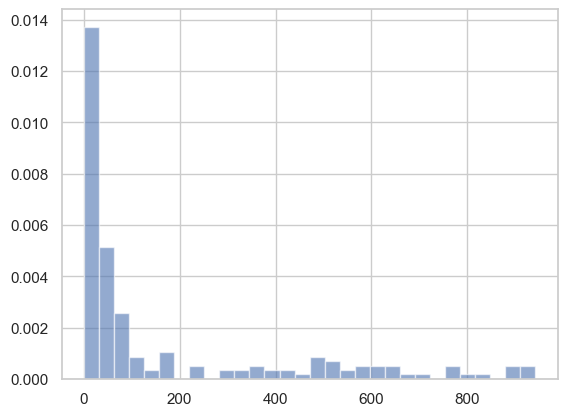

In [663]:
plt.hist(df_59980.cantidad, bins=30, density=True, alpha=0.6, color='b')
plt.show()

<Figure size 400x300 with 0 Axes>

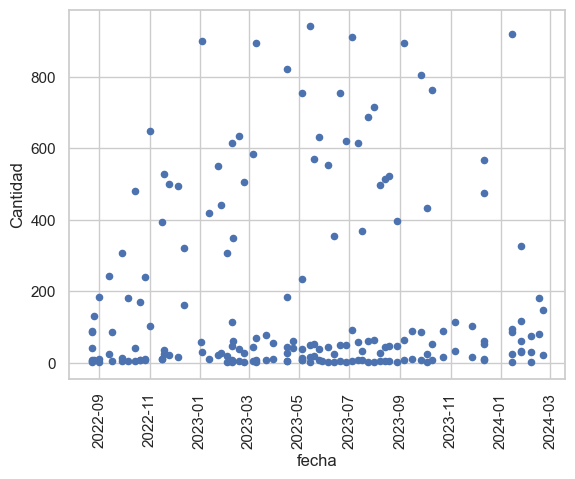

In [664]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# se realiza un un diagrama de relacion con el fin de identificar la tendencia de las unidades a reparar atravez del tiempo 
# se filtro el data set para que los datos tengan un rango desde cero hasta el cuartil 3 
plt.figure(figsize=(4, 3))
df_59980.plot(kind="scatter", x="rma_fecha_creacion", y="cantidad")
plt.xlabel("fecha")
plt.ylabel("Cantidad")
plt.xticks(rotation=90)

plt.show()


se observa un sesgo de los datos apartir de las 60 unidades y de 0 a 60, existe una tendencia creciente en los datos a medida que avanzamos desde el año 2022 hasta el 2023. Esta tendencia sugiere un aumento gradual en los valores de los datos a lo largo del tiempo. Se observa una agrupación de datos entre los meses de marzo y septiembre de 2023. Esto indica que hay un período específico durante el cual los valores de los datos están más concentrados o densamente distribuidos

HALLAZGO MEDIDAS DE CENTRALIDAD



Media: El valor promedio de unidades ha aumentado significativamente, pasando de 15 a 47 unidades en el conjunto de datos total. Este aumento está relacionado con el filtro de unidades atípicas que son mayores que la media.

Mediana: lo que nos dice es que la mitad de los datos son mayores a 26 y la otra mitad son menores a 26.
 
Rango: El rango de los datos esta distribuidos enntre 0 y 687 unidades.

HALLAZGO MEDIDAS DE DISPERSION

-La mediana, que es el valor que divide al conjunto de datos en dos partes iguales, se encuentra en 42 unidades. Esto significa que el 50% de las reparaciones tienen 42 unidades o menos, y el otro 50% tienen 42 unidades o más, por lo que los datos tienden a tener una centralidad de los datos al lado izquierdo, ya que la mediana tiene mayor proximidad al cuartil uno.

Además El primer cuartil (Q1) está en 9 unidades, lo que significa que el 25% de las reparaciones tienen 9 unidades o menos y el tercer cuartil (Q3) está en 128 unidades, lo que indica que el 75% de las reparaciones tienen 128 unidades o menos. 

La desviación estándar de los datos es de aproximadamente 60 unidades, lo que indica una dispersión de 60 unidades en relación con la media.

## Data Set Modelos

proyecto se enfoca en predecir las unidades a reparar del código 59980 para el año 2024. Este código, representativo de un componente crítico al ser el producto con mayor reparaciones realizadas y asi mismo el codigo con mayor crecimiento entre el 2022-2023, este codigo tiene un impacto directo en la continuidad operativa y la eficiencia de las operaciones.

La predicción de las unidades a reparar para el año 2024 es una tarea de vital importancia para la planificación estratégica y la asignación de recursos en el ámbito del mantenimiento industrial. La capacidad de anticipar las necesidades de reparación con anticipación permite a las organizaciones optimizar la gestión de inventario, programar adecuadamente el mantenimiento preventivo y minimizar los tiempos de inactividad no planificados.

Dada la naturaleza temporal de los datos y la necesidad de prever valores futuros, la investigación se basa en el análisis de series de tiempo. Específicamente, en emplear modelos de aprendizaje supervisado para esta tarea. En este enfoque, cada observación se asociará con un valor objetivo, en este caso, las unidades a reparar del código 59980 en un período de tiempo determinado. Utilizaremos datos históricos para entrenar nuestros modelos, con el objetivo de capturar patrones y tendencias que nos permitan realizar predicciones precisas para el año 2024.

In [666]:
#filtramos data set para el modelo de regrecion lineal 
df_regresion_lineal=df_59980[(df_59980.cantidad>Limite_inferior_59980) & (df_59980.cantidad<=Limite_superior_59980)].copy()

In [668]:
df_regresion_lineal['rma_fecha_creacion']=df_regresion_lineal.rma_fecha_creacion.dt.to_period('M')
df_regresion_lineal['rma_fecha_creacion']=df_regresion_lineal.rma_fecha_creacion.dt.to_timestamp()

# agrupamos las cantidades a reparar con las fechas 
grupo=df_regresion_lineal.groupby('rma_fecha_creacion')['cantidad'].sum().reset_index()

Cuál es la tendencia de las reparaciones asociadas al código 59980 a lo largo del tiempo

In [669]:
movil=grupo.cantidad.rolling(window=3).mean()

In [670]:

fig = go.Figure()

# Agregar la serie de datos como una línea con marcadores
fig.add_trace(go.Scatter(x=grupo.rma_fecha_creacion, y=grupo.cantidad, mode='lines+markers', marker=dict(color='blue'), line=dict(color='black', width=1)))
fig.add_trace(go.Scatter(x=grupo.rma_fecha_creacion, y=movil, mode='lines', line=dict(color='red', width=1), name='Media móvil'))

fig.update_layout(
    title='Reparaciones tendencias',
    xaxis_title='Fechas',
    yaxis_title='Cantidad',
    width=800,  # Ancho del gráfico
    height=300,  # Alto del gráfico
    xaxis=dict(
        tickmode='linear',
        dtick='M1',  
        tickformat='%b\n%Y'
    )
)

El gráfico muestra una tendencia general al  en el número de reparaciones de luminarias a lo largo del tiempo. Hay algunos picos y valles en la tendencia, pero la tedencia general es hacia arriba. Esto sugiere que se está produciendo un aumento en la necesidad de reparar luminarias durante el período de tiempo que abarca el gráfico.

In [676]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=grupo.cantidad,
    marker=dict(color='blue'),  # Color de las barras
    opacity=0.75  # Opacidad de las barras
))

# Actualizar el diseño del gráfico
fig.update_layout(
    title='Histograma',
    xaxis_title='Valor',
    yaxis_title='Frecuencia',
    width=600,
    height=300
)

# Mostrar el gráfico
fig.show()

 El histograma presenta una distribución unimodal, es decir, tiene un único pico de frecuencia. El pico se encuentra en la clase de cantidad de 1000-2000 reparaciones, con una frecuencia de 7 valores. Esto indica que esta clase de cantidad es la más frecuente. tambien el histograma presenta una ligera asimetría hacia la izquierda, Esto indica que hay una mayor cantidad de reparaciones en las clases de cantidad con valores más bajos (hacia la izquierda del histograma)

### lag and rolling

In [ ]:
ventana=[ 2,3,5,8,10,12,15]


for i in ventana:
    grupo[f'lag_mean_{i}']=grupo.cantidad.shift(i)
    grupo[f'rolling_mean_{i}']=grupo.cantidad.rolling(window=i).mean()
    grupo[f'rolling_std_{i}']=grupo.cantidad.rolling(window=i).std()
    


### LabelEncoder

In [ ]:
# aplicaos label encoder a la variable fecha de creacion
label_encoder = LabelEncoder()
grupo['rma_fecha_creacion_']=label_encoder.fit_transform(grupo.rma_fecha_creacion)

In [ ]:
fecha=grupo.rma_fecha_creacion
grupo=grupo.drop('rma_fecha_creacion',axis=1)

In [ ]:

columnas=grupo.columns.tolist()

# aplicamos simple imputer a los variables lag y rolling
imputer=SimpleImputer(strategy='median')
grupo=pd.DataFrame(imputer.fit_transform(grupo),columns=columnas)


In [ ]:
grupo = pd.concat([grupo, fecha], axis=1)
grupo = grupo.set_index('rma_fecha_creacion')
grupo.shape


(19, 23)

### Binning/Bucketing

In [ ]:
# Defino bins
bins = [1,10,20,50,100,200,300,500,700,800,900,1000,1200,1500,1800,2000,2500,2700,3000,3200,3400,4000,4500,5000,6000,7000,8000]

grupo['binned']=pd.cut(grupo.cantidad,bins=bins, labels=False)

In [ ]:
# definir variables independiente

X=grupo.drop('cantidad',axis=1)

#dependiente
y=grupo.cantidad

### Polynomial Features

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [ ]:
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns)

X = pd.DataFrame(X_poly, columns = feature_names)

### CANARITOS 

In [ ]:
np.random.seed(49150)
X_ = pd.DataFrame(np.random.rand(X.shape[0], 50), columns=[f'random_var_{i}' for i in range(50)])

In [ ]:
X=pd.concat([X,X_],axis=1)

### TRAINING AND TEST

In [ ]:
porcentaje=int(len(grupo)*0.8)

X_train,X_test= X.iloc[:porcentaje], X.iloc[porcentaje:]
y_train,y_test= y.iloc[:porcentaje], y.iloc[porcentaje:]

# se transforma y_train con el fin de usar standsclaler
y_train=np.array(y_train)
y_train=y_train.reshape(-1,1)

y_test=np.array(y_test)
y_test=y_test.reshape(-1,1)

## scaler 

In [ ]:
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
# y_train = scaler.fit_transform(y_train)
# y_test = scaler.fit_transform(y_test)


In [ ]:
# Función para obtener la ruta completa del archivo
def get_filename(file_path, experiment_name, run_name, suffix):
    if suffix.endswith('.json'):
        return os.path.join(file_path, f"{experiment_name}_{run_name}_{suffix}")
    else:
        return os.path.join(file_path, f"{experiment_name}_{run_name}_{suffix}.csv")

In [ ]:
# Creo directorio y ubicación para guardar
file_path = 'D:/ciencia de datos/analisis exploratorio/modelos/data set'
#params_file_name = get_filename(file_path, 'data_modelo_reparaciones', 'modelo_reparaciones', 'xtrain_train')

In [ ]:
y_test = pd.DataFrame(y_test, columns=['cantidad'])
y_train = pd.DataFrame(y_train, columns=['cantidad'])
X_train = pd.DataFrame(X_train, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

In [ ]:

y_test.to_csv(get_filename(file_path, 'data_modelo_reparaciones', 'y_test', '_y_test'), index=False)
y_train.to_csv(get_filename(file_path, 'data_modelo_reparaciones', 'y_train', 'y_train'), index=False)
X_train.to_csv(get_filename(file_path, 'data_modelo_reparaciones', 'X_train', 'X_train'), index=False)
X_test.to_csv(get_filename(file_path, 'data_modelo_reparaciones', 'X_test', 'X_test'), index=False)